In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [156]:
#Use clothing retain sale data from FRED (Federal Resale Economic Database)
df=pd.read_csv("RSCCASN.csv",parse_dates=True,index_col="DATE")#To reade date as datetime object and  use that column as index

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [158]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [159]:
df.columns=["Sales"]

In [160]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


<AxesSubplot:xlabel='DATE'>

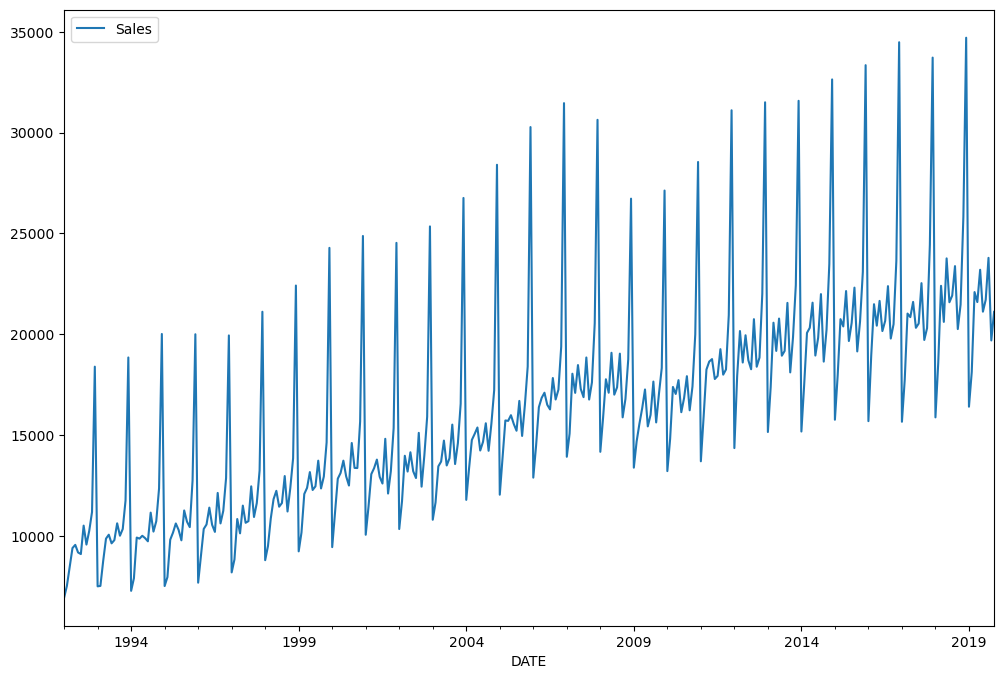

In [161]:
df.plot(figsize=(12,8))

In [162]:
len(df)

334

In [163]:
#choose test size such that it contains at least one period
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

In [164]:
train_size

233

In [165]:
val_size

50

In [166]:
train = df.iloc[:train_size]
valid = df.iloc[train_size:train_size + val_size]
test = df.iloc[train_size + val_size:]

In [167]:
#Scaling data
from sklearn.preprocessing import MinMaxScaler 

scaler=MinMaxScaler()

In [168]:
scaler.fit(train)

MinMaxScaler()

In [169]:
scaled_train = scaler.transform(train)
scaled_valid = scaler.transform(valid)
scaled_test = scaler.transform(test)

In [170]:
len(test)

51

In [171]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#Length of the batches should be less than the length of the test data to be able to do predictions for test data, so we will choose batch size of 12 months
length=12
#The source of the x points come from the scaled train, the source of the y points also
#batch_size=1 means that you will have one group in X and corresponding one value in y to be predicted 
generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)
validation_generator=TimeseriesGenerator(scaled_valid,scaled_valid,length=length,batch_size=1)
test_generator=TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)



In [172]:
X,y=generator[2]

In [173]:
X #Given the array of x, predict next value which is y

array([[[0.0626733 ],
        [0.10043223],
        [0.10683412],
        [0.0915022 ],
        [0.08828087],
        [0.14577557],
        [0.10744577],
        [0.13521448],
        [0.17325885],
        [0.46717501],
        [0.02299788],
        [0.02389496]]])

In [174]:
y

array([[0.07453923]])

In [175]:
scaled_train

array([[0.        ],
       [0.02389496],
       [0.0626733 ],
       [0.10043223],
       [0.10683412],
       [0.0915022 ],
       [0.08828087],
       [0.14577557],
       [0.10744577],
       [0.13521448],
       [0.17325885],
       [0.46717501],
       [0.02299788],
       [0.02389496],
       [0.07453923],
       [0.11943402],
       [0.12742619],
       [0.1099739 ],
       [0.11645735],
       [0.15046485],
       [0.12538738],
       [0.13896591],
       [0.19662372],
       [0.48576904],
       [0.01394552],
       [0.03930843],
       [0.12163595],
       [0.11951558],
       [0.12522427],
       [0.12049421],
       [0.11405154],
       [0.17203556],
       [0.13370576],
       [0.15462404],
       [0.22084489],
       [0.53327353],
       [0.0236503 ],
       [0.04171424],
       [0.11731365],
       [0.13170771],
       [0.15013864],
       [0.13713097],
       [0.11604958],
       [0.17639863],
       [0.15380851],
       [0.14275811],
       [0.23703311],
       [0.532

## Creating the model

In [176]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [177]:
n_features=1 #previous sales data is the only feature

In [178]:
model=Sequential()
model.add(LSTM(100,activation="relu",input_shape=(length,n_features)))   #100 neurons (you can go pretty large), input shape should be batch length vs n_features
model.add(Dense(1)) #to have one final predictive output
model.compile(optimizer="adam",loss="mse")

In [179]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [180]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [181]:
from tensorflow.keras.callbacks import EarlyStopping

In [182]:
early_stop=EarlyStopping(monitor="val_loss",patience=2)

In [183]:
model.fit(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20
221/221 [==============================] - 2s 5ms/step - loss: 0.0284 - val_loss: 0.0247
Epoch 2/20
221/221 [==============================] - 1s 4ms/step - loss: 0.0210 - val_loss: 0.0333
Epoch 3/20
221/221 [==============================] - 1s 4ms/step - loss: 0.0140 - val_loss: 0.0059
Epoch 4/20
221/221 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 5/20
221/221 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 6/20
221/221 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 7/20
221/221 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 5.3444e-04
Epoch 8/20
221/221 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/20
221/221 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 4.1917e-04
Epoch 10/20
221/221 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss

In [184]:
losses=pd.DataFrame((model.history.history))

<AxesSubplot:>

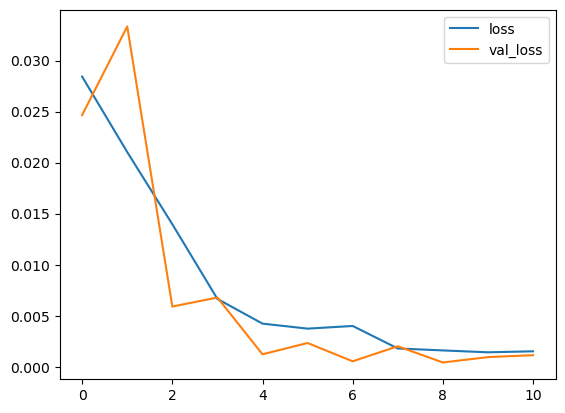

In [185]:
losses.plot()

In [186]:
predictions_scaled = model.predict(test_generator)
true_scaled = scaled_test[length:]  # Align with output

# Inverse transform both
predictions = scaler.inverse_transform(predictions_scaled)
true_values = scaler.inverse_transform(true_scaled)

39/39 [==============================] - 0s 1ms/step


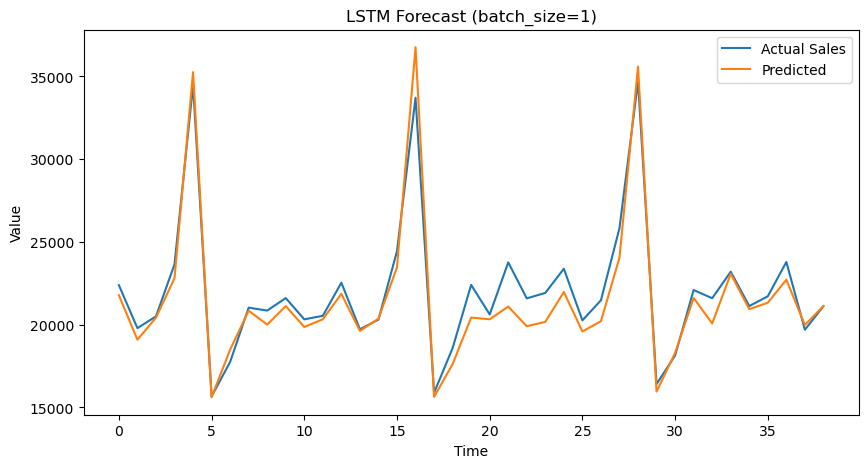

<Figure size 640x480 with 0 Axes>

In [187]:
plt.figure(figsize=(10, 5))
plt.plot(true_values, label='Actual Sales')
plt.plot(predictions, label='Predicted')
plt.title("LSTM Forecast (batch_size=1)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()
plt.savefig("Plots/Test_LSTM.png",bbox_inches="tight")

In [188]:
from sklearn.metrics import mean_squared_error 

mse = mean_squared_error(true_values, predictions)

In [189]:
np.sqrt(mse)

1073.1077001061303

In [190]:
predictions.mean()

21522.998

In [191]:
np.sqrt(mse)/predictions.mean()*100

4.985865341663861

In [192]:
#Predictions look consistent with true values

## Predicting to the future

In [193]:
forecast=[]
periods=12

first_eval_batch=scaled_test[-length:]
current_batch=first_eval_batch.reshape(1,length,n_features)

for i in range(periods):
    
    current_pred=model.predict(current_batch)[0]
    
    forecast.append(current_pred)
    
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)#remove first item from the batch and append new prediction at the end

1/1 [==============================] - 0s 17ms/step


In [194]:
forecast=scaler.inverse_transform(forecast)

In [195]:
forecast

array([[25522.23854613],
       [36876.33600044],
       [16069.85143447],
       [17915.01419854],
       [21292.74862981],
       [20956.45388722],
       [22517.35562086],
       [20654.55398822],
       [21227.93488717],
       [23166.12890601],
       [19651.11914325],
       [20931.69778562]])

In [196]:
test

,Sales
DATE,
2015-08-01,22314
2015-09-01,19151
2015-10-01,20637
2015-11-01,23090
2015-12-01,33345
2016-01-01,15694
2016-02-01,18939
2016-03-01,21492
2016-04-01,20428


In [197]:
#We build a date range index

In [198]:
forecast_index=pd.date_range(start="2019-11-01",periods=periods,freq="MS")#monthly start frequency

In [199]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [200]:
forecast_df=pd.DataFrame(data=forecast,index=forecast_index,columns=["Forecast"])

<AxesSubplot:>

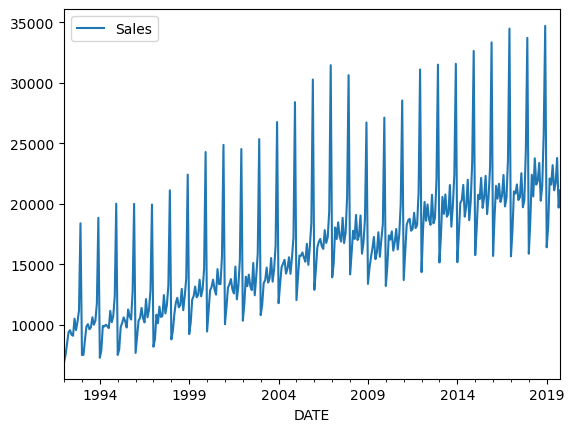

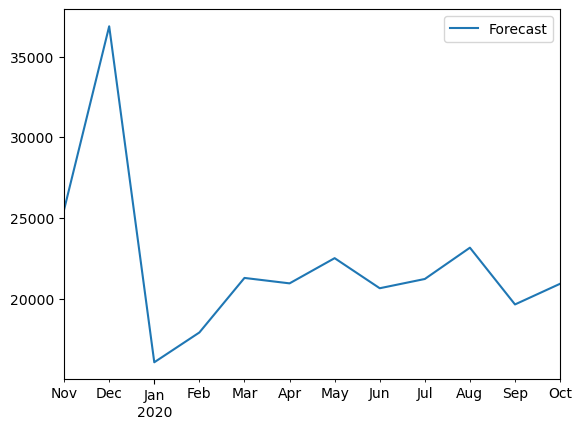

In [201]:
df.plot()
forecast_df.plot()

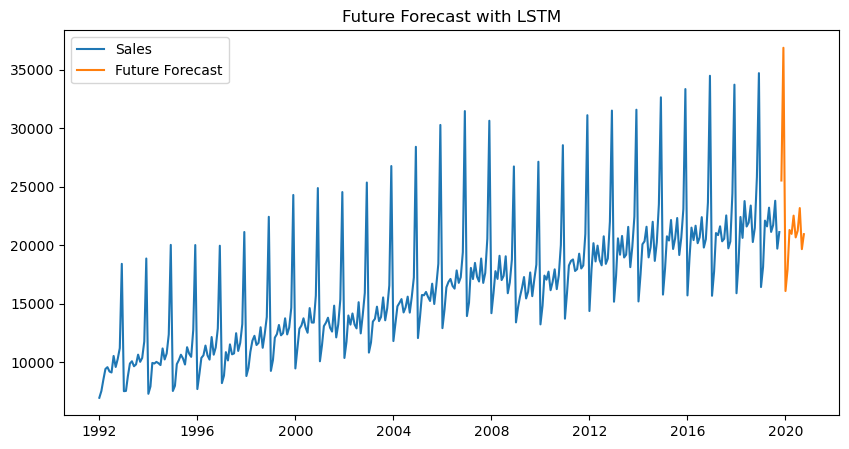

<Figure size 640x480 with 0 Axes>

In [202]:
plt.figure(figsize=(10, 5))
plt.plot(df.index,df["Sales"],label='Sales')
plt.plot(forecast_df.index,forecast_df,label='Future Forecast')
plt.title("Future Forecast with LSTM")
plt.legend()
plt.show()
plt.savefig("Plots/Futureforecast_LSTM.png",bbox_inches="tight")

## Saving the model

In [203]:
from tensorflow.keras.models import load_model

In [204]:
model.save("Clothing_sales_pred.h5")